In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2


c:\projects\HumanEmotionsPred\HumanEmo\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\projects\HumanEmotionsPred\HumanEmo\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\projects\HumanEmotionsPred\HumanEmo\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the genc

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Resizing,Rescaling,Layer,RandomContrast,RandomFlip,RandomRotation,RandomZoom,RandomCrop,InputLayer,LayerNormalization,Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint,CSVLogger,TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,InputLayer,GlobalAveragePooling2D,Dropout,Activation,Add,Input
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy

In [3]:
CONFIGS = {
    "BATCH_SIZE":32,
    "IM_SIZE": 256,
    "N_FILTERS": 32,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS":20,
    "DROPOUT_RATE": 0.0,
    "KERNEL_SIZE": 3,
    "N_FILTERS": 6,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_UNITS_1": 100,
    "N_DENSE_UNITS_2": 10,
    "NUM_CLASSES": 3,
    "REGULARIZER_RATE": 0.001,
    "OPTIMIZER": Adam(learning_rate=0.001),
    "METRICS": ['accuracy'],
    "PATCH_SIZE":16
}

In [4]:
train_dir = r"human-emotions-dataset\Emotions Dataset\Emotions Dataset\train"
val_dir = r"human-emotions-dataset\Emotions Dataset\Emotions Dataset\test"
CLASS_NAME = ["angry","happy","sad"]

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
) 

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
) 

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [6]:
test_image = cv2.imread(r"C:\projects\HumanEmotionsPred\human-emotions-dataset\EmotionsDataset\data\happy\4.jpg")
test_image = cv2.resize(test_image,(256,256))
# test_image = tf.convert_to_tensor(test_image,dtype = tf.float32)
test_image = tf.expand_dims(test_image,axis=0)

In [7]:
#  patches test
patches = tf.image.extract_patches(images=test_image,
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')



In [8]:
patches.shape#16 *16 = 256 => 256 * 3 = 768


TensorShape([1, 16, 16, 768])

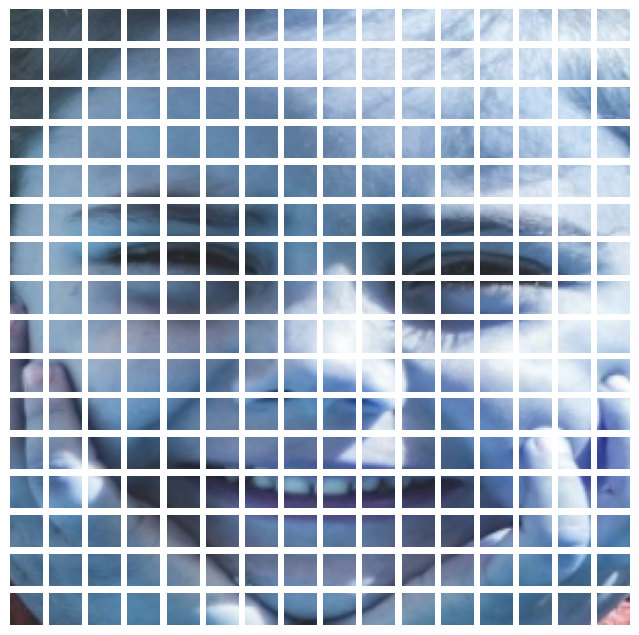

In [9]:
plt.figure(figsize=(8,8))
k = 0
for i in range(16):
    for j in range(16):
        ax = plt.subplot(16,16,k+1)

        plt.imshow(tf.reshape(patches[0,i,j,:],(16,16,3)))
        plt.axis('off')
        k+=1

In [10]:
# reshapeing patches
patches = tf.reshape(patches[0],(patches.shape[0],-1,768))
patches.shape

TensorShape([1, 256, 768])

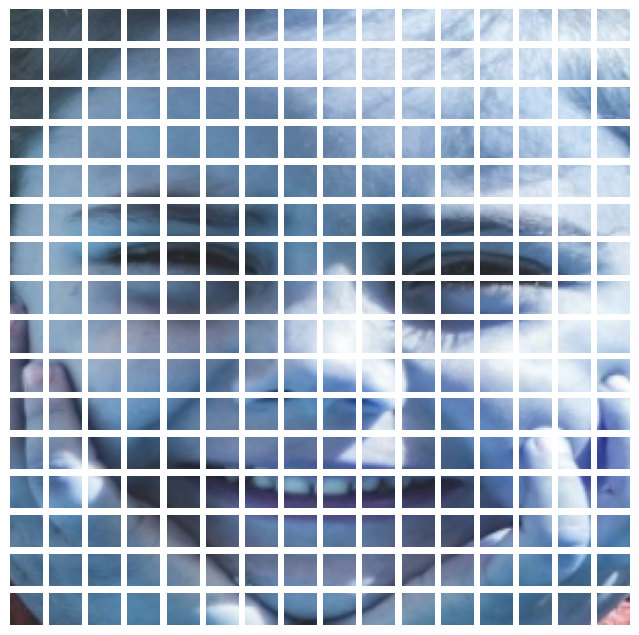

In [11]:
plt.figure(figsize=(8,8))

for i in range(patches.shape[1]):
    ax = plt.subplot(16,16,i+1)
    plt.imshow(tf.reshape(patches[0,i,:],(16,16,3)))
    plt.axis('off')

In [12]:
# patch encoding layer and postional encoding
class PatchEncodeLayer(Layer):
    def __init__(self,N_PATCHES,HIDDEN_SIZE):
        super(PatchEncodeLayer,self).__init__(name = "patch_encoder")
        self.LinearProj = Dense(HIDDEN_SIZE)
        self.postional_embed = tf.keras.layers.Embedding(N_PATCHES,HIDDEN_SIZE)
        self.n_patches = N_PATCHES

    def call(self,x):
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, CONFIGS['PATCH_SIZE'], CONFIGS['PATCH_SIZE'], 1],
            strides=[1, CONFIGS['PATCH_SIZE'], CONFIGS['PATCH_SIZE'], 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
            )
        
        patches = tf.reshape(patches,(tf.shape(patches)[0],256,patches.shape[-1]))
        embed_imput = tf.range(start = 0,limit = self.n_patches,delta =1)
        out = self.LinearProj(patches) + self.postional_embed(embed_imput)

        return out


In [13]:
patch_enc = PatchEncodeLayer(256,768)
patch_enc(tf.zeros([32,256,256,3]))


<tf.Tensor: shape=(32, 256, 768), dtype=float32, numpy=
array([[[ 0.00453336,  0.02291187, -0.01800631, ..., -0.020309  ,
         -0.04146175,  0.0132619 ],
        [-0.01360655, -0.01187301,  0.04416562, ...,  0.04931203,
          0.01764545,  0.03275246],
        [-0.02222209,  0.0084474 , -0.03669956, ..., -0.01381759,
         -0.01910779, -0.02657687],
        ...,
        [-0.01632843, -0.00362141,  0.00918801, ..., -0.02872808,
          0.01544585, -0.03541559],
        [-0.03654676, -0.03786027,  0.01383107, ..., -0.02444546,
         -0.04508818,  0.04321047],
        [ 0.01583945, -0.04018288, -0.02234405, ..., -0.01571833,
         -0.04943892, -0.02775589]],

       [[ 0.00453336,  0.02291187, -0.01800631, ..., -0.020309  ,
         -0.04146175,  0.0132619 ],
        [-0.01360655, -0.01187301,  0.04416562, ...,  0.04931203,
          0.01764545,  0.03275246],
        [-0.02222209,  0.0084474 , -0.03669956, ..., -0.01381759,
         -0.01910779, -0.02657687],
        ...

In [14]:
# Transformation encoder

class TransformerEncoder(Layer):
    def __init__(self,N_HEADS,HIDDEN_SIZE):
        super(TransformerEncoder,self).__init__(name = 'transformer_encoder')
        # 1. Layer norm
        self.layer_norm1 = LayerNormalization()
        self.layer_norm2 = LayerNormalization()
        # 2. Multi head attention

        self.multiHead = tf.keras.layers.MultiHeadAttention(
            N_HEADS,HIDDEN_SIZE
        )
        # 3 dense layers 

        self.dense_1 = Dense(HIDDEN_SIZE,activation = tf.nn.gelu)
        self.dense_2 = Dense(HIDDEN_SIZE,activation = tf.nn.gelu)


    def call(self,input):
        x = self.layer_norm1(input)
        x = self.multiHead(x,x)

        x = Add()([x,input])

        y = self.layer_norm2(x)


        y = self.dense_1(y) 

        out = self.dense_2(y)

        output = Add()([out,x])

        return out


In [15]:
transformer_1 = TransformerEncoder(8,768)
transformer_1(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]],
      shape=(1, 256, 768), dtype=float32)>

In [16]:
#  Summing everything and making a a ViT

class ViT(Model):
    def __init__(self,N_HEADS,HIDDEN_SIZE,N_PATCHES,N_LAYERS,N_DENSE_UNITS):
        super(ViT,self).__init__(name = 'Vision_Transformer')
        self.n_layers = N_LAYERS
        self.patch_encoder = PatchEncodeLayer(N_PATCHES,HIDDEN_SIZE)
        self.transformer_encoder = [TransformerEncoder(N_HEADS,HIDDEN_SIZE) for _ in range(N_LAYERS)]
        self.dense_1 = Dense(N_DENSE_UNITS,activation=tf.nn.gelu)
        self.dense_2 = Dense(N_DENSE_UNITS,activation=tf.nn.gelu)
        self.dense_3 = Dense(CONFIGS['NUM_CLASSES'],activation='softmax')
    def call(self,input ,training=True):

        x = self.patch_encoder(input)
        for i in range(self.n_layers):
            x = self.transformer_encoder[i](x)

        x = Flatten()(x)

        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x)
    

In [17]:
# vit_model =  ViT(N_HEADS=8,HIDDEN_SIZE=768,N_PATCHES = 256,N_LAYERS=4,N_DENSE_UNITS=1024)
vit_model =  ViT(N_HEADS=4,HIDDEN_SIZE=768,N_PATCHES = 256,N_LAYERS=2,N_DENSE_UNITS=128)

vit_model(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
       [0.40883887, 0.23868144, 0.3524797 ],
      

In [18]:
vit_model.summary()

Model: "Vision_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_encoder                   │ ?                      │       787,200 │
│ (PatchEncodeLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 128)              │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,232,899 (180.18 MB)

 Trainable params: 47,232,899 (180.18 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [20]:
vit_model.compile(
    optimizer = CONFIGS['OPTIMIZER'],
    loss = 'categorical_crossentropy',
    metrics = metrics
)



In [21]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint,CSVLogger,TensorBoard
earlystop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)


reduced_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [22]:
# history = vit_model.fit(
#     train_dataset
#     ,validation_data=val_dataset,
#     epochs = CONFIGS['N_EPOCHS'],
#     verbose = 1,
#     callbacks = [earlystop])

Epoch 1/20
 14/213 ━━━━━━━━━━━━━━━━━━━━ 1:36:24 29s/step - accuracy: 0.3624 - loss: 31.3239 - top_k_accuracy: 0.6708

KeyboardInterrupt: 

In [ ]:
for layer in vit_model.layers:
    print(layer.name)

patch encoder
transformer_encoder
transformer_encoder
dense_54
dense_55
dense_56
